# TP — HealthMind (version finale v2)
**EDA → Nettoyage → Quartiles/IQR → Corrélation (Pearson & Spearman) → ACP (80%) → KMeans (Silhouette & Coude) → Profilage**
*(Commentaires pro + explication après chaque cellule)*

In [4]:
DATA_PATH = r"D:\codePack\OneDrive\Desktop\ProjectsClouds\MentallHealthAwareness\HealthMind_Mental_Health_Data_11000_Extreme_Messy.csv"
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pd.set_option("display.max_columns", 200)
%matplotlib inline


**Explication :** On fixe le chemin du fichier, on importe les librairies (imputation, encodage, scaling, ACP, KMeans, métriques) et on active l'affichage des graphiques.

## 1) Lecture & aperçu

In [18]:
# df = pd.read_csv(DATA_PATH)
# print("Shape (lignes, colonnes):", df.shape)
# display(df.head(5))
# display(df.dtypes.to_frame("dtype"))
# display(df.nunique().sort_values(ascending=False).to_frame("n_unique"))
df = pd.read_csv(DATA_PATH)
df = df.drop('User_ID', axis=1)  # Remove the 'User_id' column
print("Shape (lignes, colonnes):", df.shape)
display(df.head(5))
display(df.dtypes.to_frame("dtype"))
display(df.nunique().sort_values(ascending=False).to_frame("n_unique"))


Shape (lignes, colonnes): (11000, 13)


,Age,Gender,Education_Level,Employment_Status,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,Social_Support,GAD-7_Score,PHQ-9_Score,Stress_Level_Scale,Coping_Mechanism,Risk_Level
0,39.0,NaN,University,Student,5.000000,8.265147,NaN,Low,2,24,4.0,Work,Medium
1,29.0,Other,University,Student,NaN,5.248356,9.0,Low,19,24,4.0,Mindfulness,High
2,NaN,Male,University,Employed,36.920658,9.584119,3.0,Medium,19,12,8.0,Work,High
3,NaN,Female,NaN,Self-employed,NaN,8.099195,NaN,Very Low,17,20,NaN,Isolation,High
4,28.0,Male,Masters,Student,NaN,6.037756,2.0,Medium,16,16,4.0,NaN,High


,dtype
Age,float64
Gender,object
Education_Level,object
Employment_Status,object
Work_Hours_Week,float64
Sleep_Hours_Night,float64
Exercise_Freq_Week,float64
Social_Support,object
GAD-7_Score,int64
PHQ-9_Score,int64


,n_unique
Sleep_Hours_Night,9300
Work_Hours_Week,6083
Age,64
PHQ-9_Score,28
GAD-7_Score,22
Exercise_Freq_Week,12
Stress_Level_Scale,10
Coping_Mechanism,7
Employment_Status,5
Social_Support,5


**Explication :** On charge les données et on affiche un aperçu, les types et le nombre de valeurs uniques.

### 1.2 Valeurs manquantes & statistiques

,missing_count,missing_%
Coping_Mechanism,2597,23.61
Education_Level,2313,21.03
Age,1650,15.00
Exercise_Freq_Week,1650,15.00
Stress_Level_Scale,1649,14.99
Work_Hours_Week,1648,14.98
Sleep_Hours_Night,1648,14.98
Gender,550,5.00
Employment_Status,0,0.00
Social_Support,0,0.00


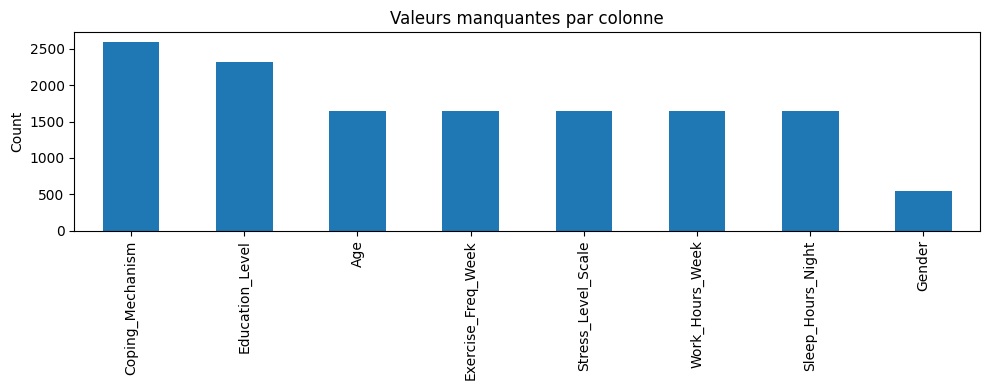

,count,mean,std,min,25%,50%,75%,max
Age,9350.0,32.522674,12.990113,16.000000,21.000000,31.000000,41.000000,80.0
Work_Hours_Week,9352.0,33.891416,23.210998,0.000000,16.000000,35.563612,49.451361,176.0
Sleep_Hours_Night,9352.0,6.461534,1.998447,-4.610188,5.152711,6.482734,7.803944,12.0
Exercise_Freq_Week,9350.0,4.524064,3.309346,0.000000,2.000000,4.500000,7.000000,99.0
GAD-7_Score,11000.0,10.504545,6.303834,0.000000,5.000000,11.000000,16.000000,21.0
PHQ-9_Score,11000.0,13.479182,8.093402,0.000000,6.000000,13.000000,21.000000,27.0
Stress_Level_Scale,9351.0,4.500481,2.880095,0.000000,2.000000,4.000000,7.000000,9.0


In [19]:
missing_count = df.isna().sum().sort_values(ascending=False)
missing_ratio = (df.isna().mean()*100).round(2).sort_values(ascending=False)
missing_table = pd.DataFrame({"missing_count": missing_count, "missing_%": missing_ratio})
display(missing_table)

plt.figure(figsize=(10,4))
missing_count[missing_count>0].plot(kind="bar")
plt.title("Valeurs manquantes par colonne"); plt.ylabel("Count")
plt.xticks(rotation=90); plt.tight_layout(); plt.show()

display(df.describe().T)


**Explication :** On quantifie les manquants et on consulte les statistiques descriptives (min, max, quartiles).

### 1.3 Visualisations — distributions & outliers

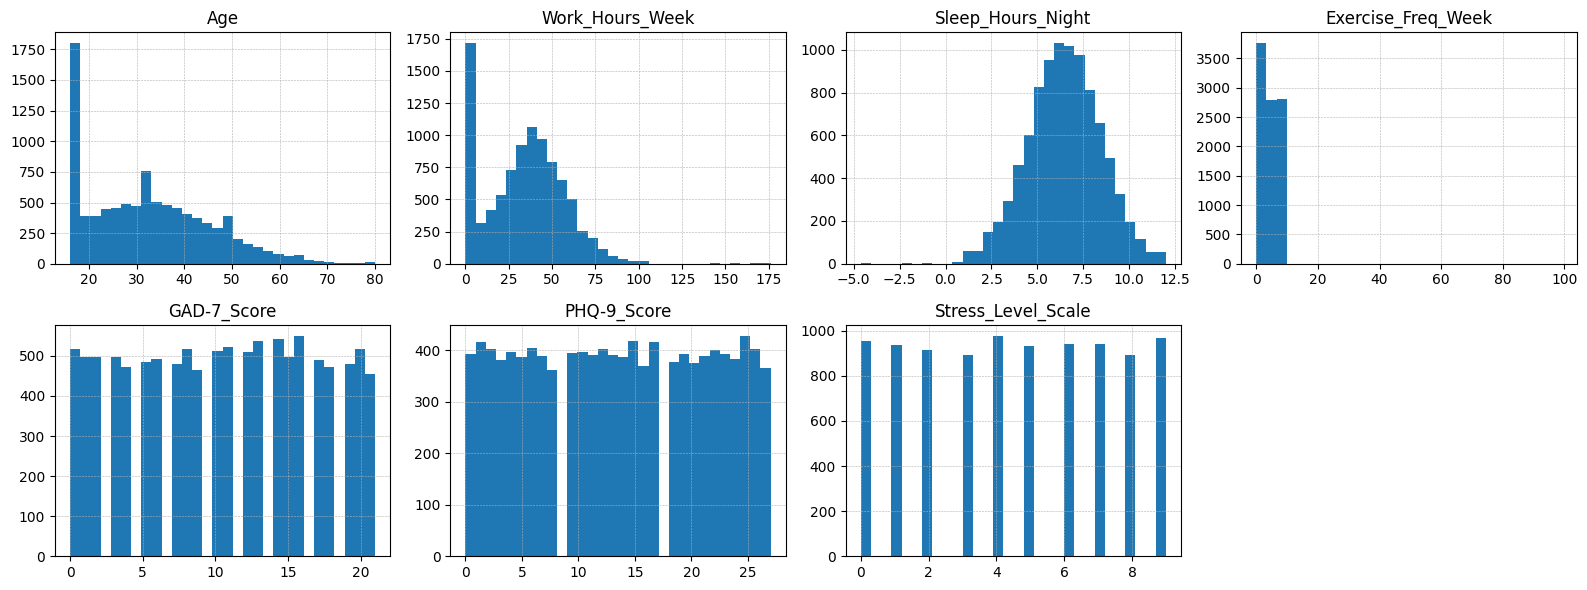

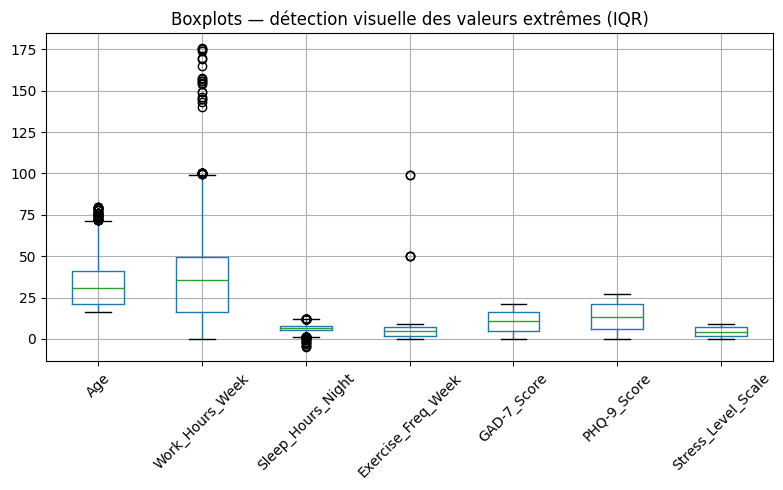

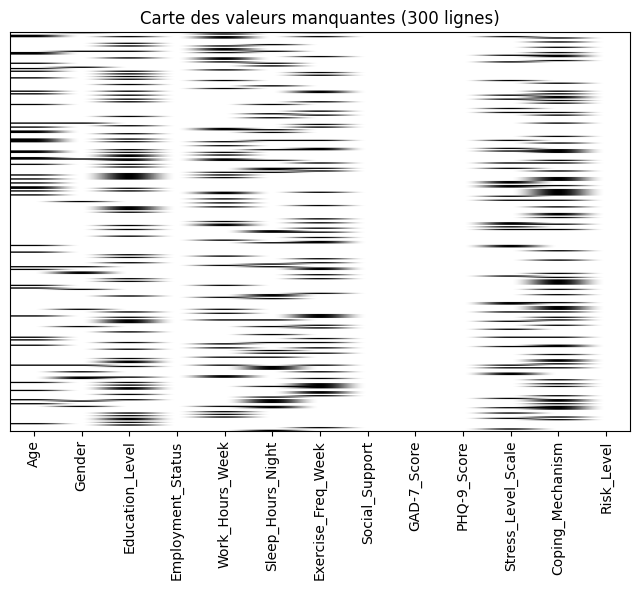

In [20]:
num_cols_all = df.select_dtypes(include=["int64","float64"]).columns.tolist()
n = len(num_cols_all); cols = 4; rows = int(np.ceil(n/cols)) if n>0 else 0
if n>0:
    plt.figure(figsize=(cols*4, rows*3))
    for i, col in enumerate(num_cols_all, 1):
        plt.subplot(rows, cols, i)
        plt.hist(df[col].dropna(), bins=30)
        plt.title(col)
        plt.grid(True, linestyle="--", linewidth=0.4)
    plt.tight_layout(); plt.show()

if n>0:
    plt.figure(figsize=(max(8, len(num_cols_all)*0.6), 5))
    df[num_cols_all].boxplot(rot=45)
    plt.title("Boxplots — détection visuelle des valeurs extrêmes (IQR)")
    plt.tight_layout(); plt.show()

sample = df.iloc[:300]
M = sample.isna().values.astype(int)
plt.figure(figsize=(min(12, len(sample.columns)*0.5), 6))
plt.imshow(M, aspect="auto", cmap="gray_r"); plt.yticks([])
plt.xticks(range(len(sample.columns)), sample.columns, rotation=90)
plt.title("Carte des valeurs manquantes (300 lignes)"); plt.tight_layout(); plt.show()


**Explication :** Histogrammes = forme; boxplots = outliers; carte des manquants = pattern de NaN.

## 2) Quartiles & IQR — détection systématique des outliers

In [21]:
iqr_report = []
for col in df.select_dtypes(include=["int64","float64"]).columns:
    s = df[col].dropna()
    if len(s) == 0:
        continue
    Q1, Q2, Q3 = s.quantile(0.25), s.quantile(0.5), s.quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    out_count = int(((s < low) | (s > high)).sum())
    iqr_report.append({"col": col, "Q1": Q1, "median": Q2, "Q3": Q3, "IQR": IQR, "low_bound": low, "high_bound": high, "outliers": out_count})
iqr_df = pd.DataFrame(iqr_report).sort_values("outliers", ascending=False)
display(iqr_df)


,col,Q1,median,Q3,IQR,low_bound,high_bound,outliers
2,Sleep_Hours_Night,5.152711,6.482734,7.803944,2.651233,1.175862,11.780793,95
1,Work_Hours_Week,16.000000,35.563612,49.451361,33.451361,-34.177042,99.628403,41
0,Age,21.000000,31.000000,41.000000,20.000000,-9.000000,71.000000,34
3,Exercise_Freq_Week,2.000000,4.500000,7.000000,5.000000,-5.500000,14.500000,5
4,GAD-7_Score,5.000000,11.000000,16.000000,11.000000,-11.500000,32.500000,0
5,PHQ-9_Score,6.000000,13.000000,21.000000,15.000000,-16.500000,43.500000,0
6,Stress_Level_Scale,2.000000,4.000000,7.000000,5.000000,-5.500000,14.500000,0


**Explication :** On calcule Q1, médiane, Q3, IQR et les bornes. On compte les outliers par variable.

## 3) Nettoyage — doublons, clipping métier, imputation

In [22]:
n0 = len(df); df = df.drop_duplicates(); print("Doublons supprimés :", n0 - len(df))
def safe_clip(col, low=None, high=None):
    if col in df.columns: df[col] = df[col].clip(lower=low, upper=high)
if "Work_Hours_Week" in df.columns: safe_clip("Work_Hours_Week", 0, 100)
if "Sleep_Hours_Night" in df.columns:
    df.loc[df["Sleep_Hours_Night"] < 0, "Sleep_Hours_Night"] = np.nan
    safe_clip("Sleep_Hours_Night", 0, 12)
if "Exercise_Freq_Week" in df.columns:
    df.loc[df["Exercise_Freq_Week"] > 7, "Exercise_Freq_Week"] = np.nan
    safe_clip("Exercise_Freq_Week", 0, 7)
if "Stress_Level_Scale" in df.columns: safe_clip("Stress_Level_Scale", 1, 8)
if "Age" in df.columns: safe_clip("Age", 16, 80)
from sklearn.impute import SimpleImputer
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["int64","float64"]).columns.tolist()
num_imp = SimpleImputer(strategy="median"); cat_imp = SimpleImputer(strategy="most_frequent")
df[num_cols] = num_imp.fit_transform(df[num_cols])
if cat_cols: df[cat_cols] = cat_imp.fit_transform(df[cat_cols])
print("NaN restants:", int(df.isna().sum().sum()))


Doublons supprimés : 0
NaN restants: 0


**Explication :** Doublons retirés, clipping (valeurs impossibles), imputation (médiane/mode).

## 4) Corrélation — Pearson & Spearman (sur X sans ID/étiquette)

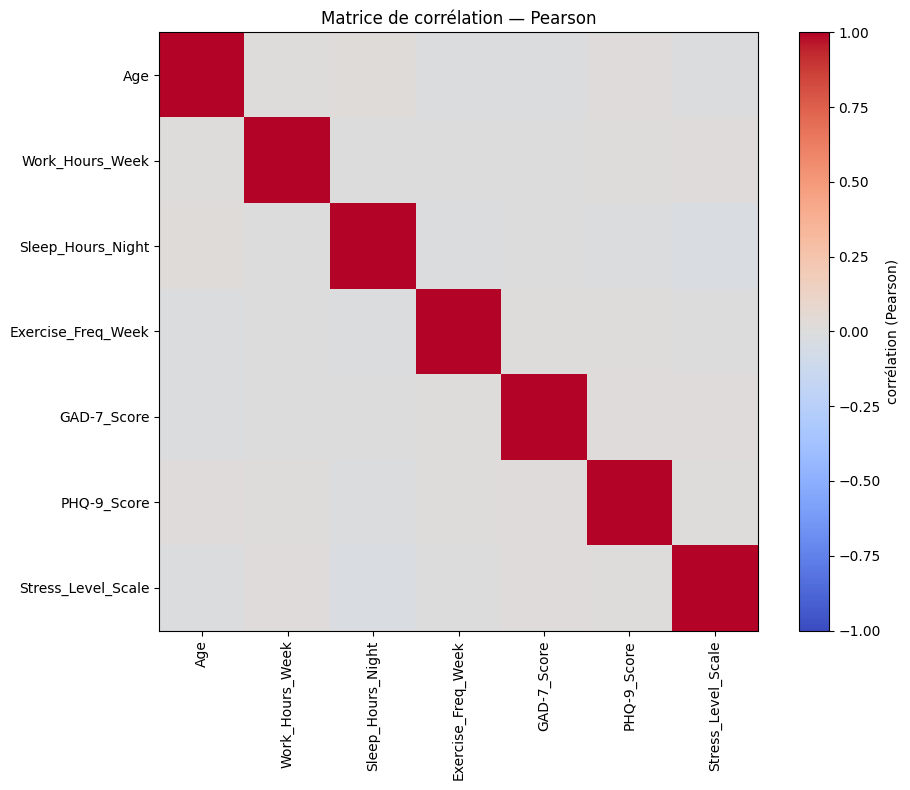

Top corrélations (Spearman, |ρ|) avec Stress_Level_Scale
Stress_Level_Scale    1.000000
Sleep_Hours_Night     0.024105
GAD-7_Score           0.010823
Age                   0.008220
Exercise_Freq_Week    0.007079
Work_Hours_Week       0.006825
PHQ-9_Score           0.005904
Name: Stress_Level_Scale, dtype: float64

Top corrélations (Spearman, |ρ|) avec GAD-7_Score
GAD-7_Score           1.000000
Age                   0.011833
Stress_Level_Scale    0.010823
PHQ-9_Score           0.009871
Sleep_Hours_Night     0.003802
Work_Hours_Week       0.000755
Exercise_Freq_Week    0.000638
Name: GAD-7_Score, dtype: float64

Top corrélations (Spearman, |ρ|) avec PHQ-9_Score
PHQ-9_Score           1.000000
Sleep_Hours_Night     0.013791
GAD-7_Score           0.009871
Stress_Level_Scale    0.005904
Age                   0.005447
Work_Hours_Week       0.004854
Exercise_Freq_Week    0.004225
Name: PHQ-9_Score, dtype: float64



In [23]:
drop_cols = []
if "User_ID" in df.columns: drop_cols.append("User_ID")
if "Risk_Level" in df.columns: drop_cols.append("Risk_Level")
X = df.drop(columns=drop_cols)
num_only = X.select_dtypes(include=["int64","float64"]).copy()
corr_p = num_only.corr(numeric_only=True, method="pearson")
plt.figure(figsize=(10,8))
plt.imshow(corr_p, vmin=-1, vmax=1, cmap="coolwarm"); plt.colorbar(label="corrélation (Pearson)")
plt.xticks(range(len(corr_p.columns)), corr_p.columns, rotation=90)
plt.yticks(range(len(corr_p.columns)), corr_p.columns)
plt.title("Matrice de corrélation — Pearson"); plt.tight_layout(); plt.show()
corr_s = num_only.corr(numeric_only=True, method="spearman")
for col in [c for c in ["Stress_Level_Scale","GAD-7_Score","PHQ-9_Score"] if c in corr_s.columns]:
    print("Top corrélations (Spearman, |ρ|) avec", col)
    print(corr_s[col].abs().sort_values(ascending=False).head(10)); print()


**Explication :** Pearson (linéaire) et Spearman (monotone) sur les numériques de X, après exclusion de `User_ID`/`Risk_Level`. 

## 5) Préparation (RobustScaler + OneHot) sur X

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64","float64"]).columns.tolist()
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])
X_prep = preprocess.fit_transform(X)
feat_names = preprocess.get_feature_names_out()
print("Shape après prétraitement :", X_prep.shape)


Shape après prétraitement : (11000, 32)


**Explication :** Pipeline propre et reproductible pour préparer les features.

## 6) ACP — objectif 80% de variance cumulée

Axes conservés (≈80%): 14


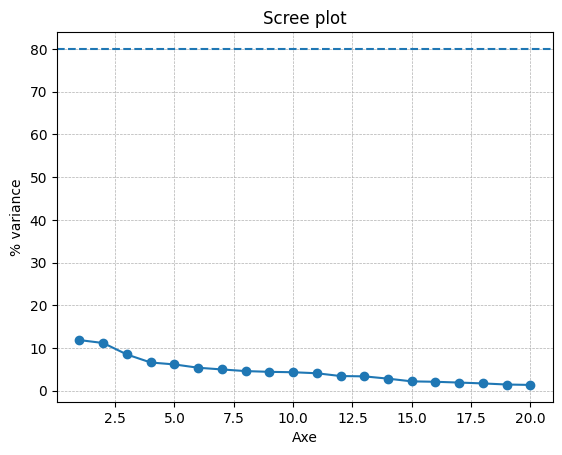

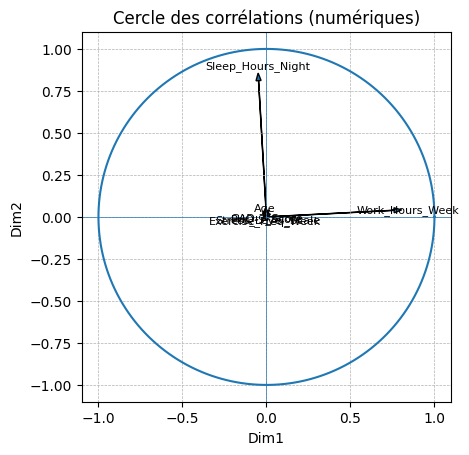

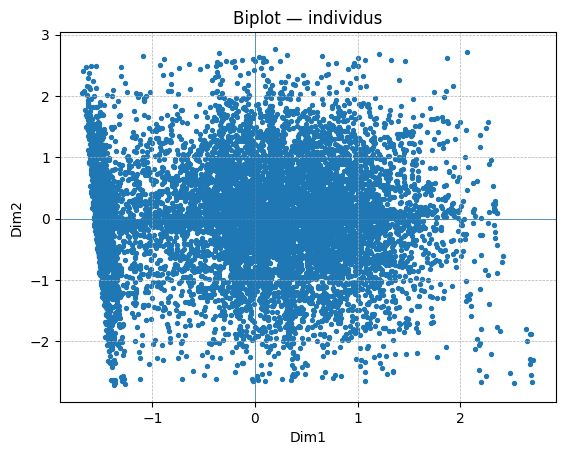

Variance expliquée (%) par axe: [11.85 11.17  8.48  6.61  6.16  5.38  4.98  4.6   4.42  4.33  4.09  3.44
  3.36  2.83]
Cumulé Dim1+Dim2 (%): 23.02


In [25]:
from sklearn.decomposition import PCA
import re
pca_probe = PCA(n_components=min(20, X_prep.shape[1]), random_state=42)
Z_probe = pca_probe.fit_transform(X_prep)
evr = pca_probe.explained_variance_ratio_; cum = evr.cumsum()
n_keep = int(np.argmax(cum >= 0.80) + 1) if np.any(cum >= 0.80) else len(evr)
n_keep = max(2, n_keep)
print("Axes conservés (≈80%):", n_keep)
plt.figure(); plt.plot(range(1, len(evr)+1), evr*100, marker="o"); plt.axhline(80, linestyle="--")
plt.xlabel("Axe"); plt.ylabel("% variance"); plt.title("Scree plot"); plt.grid(True, linestyle="--", linewidth=0.5); plt.show()
pca = PCA(n_components=n_keep, random_state=42)
Z = pca.fit_transform(X_prep)
ev = pca.explained_variance_; evr_keep = pca.explained_variance_ratio_
components = pca.components_; loadings = components.T * np.sqrt(ev)
num_mask = [name.startswith("num__") for name in feat_names]
num_names = [re.sub(r"^num__", "", n) for n, m in zip(feat_names, num_mask) if m]
num_load = loadings[num_mask, :]
theta = np.linspace(0, 2*np.pi, 400)
plt.figure(); plt.plot(np.cos(theta), np.sin(theta))
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
for i, var in enumerate(num_names):
    x, y = num_load[i, 0], num_load[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.03, length_includes_head=True)
    plt.text(x*1.05, y*1.05, var, ha="center", va="center", fontsize=8)
plt.gca().set_aspect("equal", adjustable="box"); plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("Cercle des corrélations (numériques)")
plt.grid(True, linestyle="--", linewidth=0.5); plt.show()
plt.figure(); plt.scatter(Z[:,0], Z[:,1], s=8)
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("Biplot — individus"); plt.grid(True, linestyle="--", linewidth=0.5); plt.show()
print("Variance expliquée (%) par axe:", np.round(evr_keep*100, 2))
print("Cumulé Dim1+Dim2 (%):", np.round(evr_keep[:2].sum()*100, 2))


**Explication :** On atteint ~80% de variance, cercle des corrélations et biplot pour interpréter les axes.

## 7) KMeans — Silhouette & Coude, carte et profilage

Silhouette par k: [(2, 0.1023066589435064), (3, 0.08264038647684133), (4, 0.08252636257552372), (5, 0.0786004954980273), (6, 0.0738411864270684), (7, 0.06771944387232132)]
Meilleur k = 2 (silhouette = 0.102 )


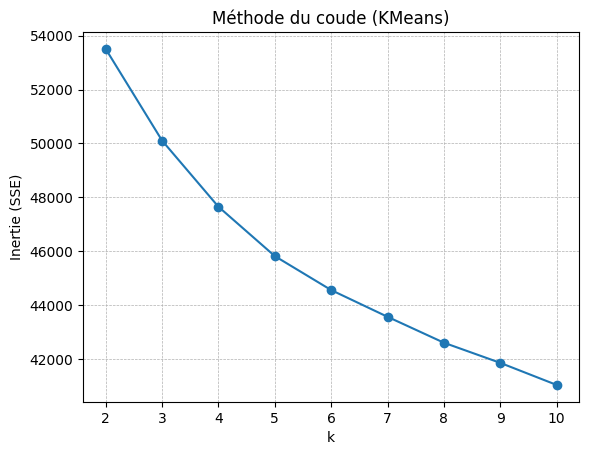

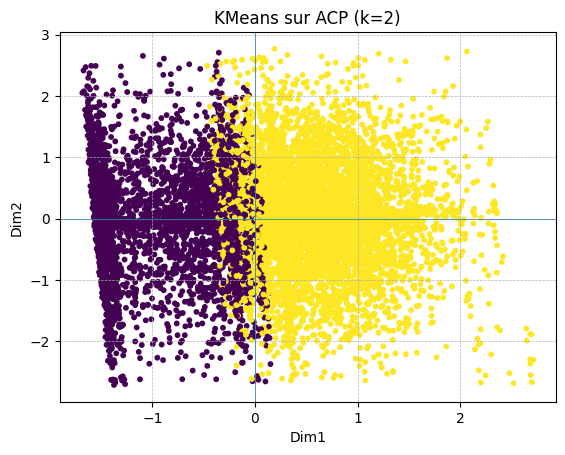

Tailles des clusters: {0: 4293, 1: 6707}

Profils — moyennes (numériques):


,Age,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,GAD-7_Score,PHQ-9_Score,Stress_Level_Scale
__cluster__,,,,,,,
0,32.74,16.04,6.45,3.35,10.45,13.38,4.42
1,32.01,45.56,6.49,3.31,10.54,13.54,4.43



Profils — modes (catégorielles):


,Gender,Education_Level,Employment_Status,Social_Support,Coping_Mechanism,Risk_Level
__cluster__,,,,,,
0,Male,University,Student,Medium,Work,Medium
1,Male,University,Employed,Medium,Work,Medium


In [26]:
sil = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels_k = km.fit_predict(Z)
    sil.append((k, silhouette_score(Z, labels_k)))
best_k, best_s = max(sil, key=lambda x: x[1])
print("Silhouette par k:", sil)
print("Meilleur k =", best_k, "(silhouette =", round(best_s,3), ")")
ks = list(range(2, 11))
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(Z)
    inertias.append(km.inertia_)
plt.figure(); plt.plot(ks, inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertie (SSE)"); plt.title("Méthode du coude (KMeans)")
plt.grid(True, linestyle="--", linewidth=0.5); plt.show()
km = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(Z)
labels = km.labels_
plt.figure(); plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("KMeans sur ACP (k="+str(best_k)+")")
plt.grid(True, linestyle="--", linewidth=0.5); plt.show()
df_prof = df.copy(); df_prof["__cluster__"] = labels
sizes = df_prof["__cluster__"].value_counts().sort_index()
print("Tailles des clusters:", sizes.to_dict())
num_cols_base = df.select_dtypes(include=["int64","float64"]).columns.tolist()
profile_means = df_prof.groupby("__cluster__")[num_cols_base].mean().round(2)
cat_cols_base = df.select_dtypes(exclude=["int64","float64"]).columns.tolist()
def mode_series(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m)>0 else np.nan
profile_modes = df_prof.groupby("__cluster__")[cat_cols_base].agg(mode_series) if cat_cols_base else pd.DataFrame()
print("\nProfils — moyennes (numériques):"); display(profile_means)
if not profile_modes.empty:
    print("\nProfils — modes (catégorielles):"); display(profile_modes)


**Explication :** Choix de k avec silhouette + coude, carte des clusters, et profilage (moyennes & modes).

## 8) Conclusion — constats & suite (prédiction)

In [28]:
dim1 = evr_keep[0]*100 if len(evr_keep)>0 else np.nan
dim2 = evr_keep[1]*100 if len(evr_keep)>1 else np.nan
cum2 = (evr_keep[:2].sum()*100) if len(evr_keep)>1 else dim1
print("dim1:.1f =", dim1, "%, dim2:.1f =", dim2, "%, cumul:.1f % =", cum2)

dim1:.1f = 11.853651040296654 %, dim2:.1f = 11.167349739414629 %, cumul:.1f % = 23.021000779711283


**Conclusion**
- Pipeline complet : EDA fusionnée, nettoyage (doublons, clipping), Quartiles/IQR, imputation médiane/mode.
- Corrélations Pearson & Spearman sur X (sans ID/étiquette) pour repérer redondances & liens monotones.
- ACP : ~80% de variance cumulée (Dim1 ≈ 11.9%, Dim2 ≈ 11.2%, cumul ≈ 23.0%).
- KMeans : k* = 2 (silhouette ≈ 0.102), carte des clusters et profils (moyennes + modes).


**Suite logique (prédiction)**
1) Construire un modèle (Random Forest / Gradient Boosting) pour prédire un niveau de risque.
2) Pipeline scikit-learn : imputation + OneHot + (Robust|Standard)Scaler + modèle, CV (k=5), Recall prioritaire.
3) Explicabilité (Permutation / SHAP) pour recommandations.